This model tries to optimize stress-strain state (reduce displacements to acceptable level) by combination of simple finite element analysis and reinforcement learning.

In essence, it is a simple form of material optimization.

In [1]:
import numpy as np
import gym
from gym import spaces
import time
import random
from stable_baselines3 import A2C, SAC,PPO
import torch
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import os

In [3]:
torch.__version__

'1.13.1'

In [4]:
gym.__version__

'0.21.0'

# Finite Element Model of Axially Loaded Bar

In [5]:
# Details of model can be found at:
# https://en.wikiversity.org/wiki/Introduction_to_finite_elements/Axial_bar_finite_element_solution

In [6]:
def elementStiffness(A, E, h):
    s= A*E/h
    return s*np.array([[1,-1],[-1,1]])

In [7]:
def elementLoad(node1, node2, a, h):

    x1 = node1
    x2 = node2

    fe1 = a*x2/(2*h)*(x2**2-x1**2) - a/(3*h)*(x2**3-x1**3)
    fe2 = -a*x1/(2*h)*(x2**2-x1**2) + a/(3*h)*(x2**3-x1**3)
    return np.array([fe1,fe2])

In [8]:
def AxialBarFEM(A,E):
    L = 1.0
    a = 1.0
    R = 1.0    
    e = 3
    h = L/e
    n = e+1
        
    node=[]    
    for i in range(n):
        node.append(i*h)
    node=np.array(node) 
        
    elem=[]    
    for i in range(e):
        P=[i,i+1]
        elem.append(P)
    elem=np.array(elem)    
      
    K=np.zeros((n,n))   
    F=np.zeros((n,1))  
       
    for i in range(e):
        node1 = elem[i,0]
        node2 = elem[i,1]
        Ke = elementStiffness(A, E, h)
        fe = elementLoad(node[node1],node[node2], a, h)
        K[node1:node2+1,node1:node2+1] = K[node1:node2+1,node1:node2+1] + Ke
        F[node1:node2+1] = F[node1:node2+1] + fe.reshape(2,1)
         
    F[n-1] = F[n-1] + 1.0
   
    bc_node=[0]
    bc_val=[0]
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d[-1],A,E

In [9]:
# Input: cross-sectional area and Young's modulus
# Output: largest displacement at rightmost node at the point of external force application

DIM=len(AxialBarFEM(0.5, 1))+1

## Utils

In [10]:
def prestep(action,A,E):
    d=0.01
    d1=0.005
    if action==0:
        return A-d, E
    elif action==1:
        return A-d,E-d1
    elif action==2:
        return A-d,E+d1
    elif action==3:
        return A,E
    elif action==4:
        return A+d,E
    elif action==5:
        return A+d, E+d1
    elif action==6:
        return A+d, E-d1
    elif action==7:
        return A, E+d1
    else:
        return A,E-d1

In [11]:
def reward_(obs_,obs):
#     if obs_[1]>obs[1]: # use when minimizing cross-sectional area
    if obs_[0]>obs[0]:  # use when minimizing displacement  
        return 1
    else:
        return 0

## Reinforcement learning model

In [12]:
N_DISCRETE_ACTIONS=8

In [13]:
class BarEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        
        self.A=3*random.random()
        self.E=2*random.random()
        self.obs=list(AxialBarFEM(self.A, self.E))+[0]   
        self.observation_space = spaces.Box(low=np.array([-np.inf for x in range(DIM)]),
                                            high=np.array([np.inf for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        self.needs_reset = True

    def step(self, action):
        
        obs_=self.obs
        self.A,self.E=prestep(action,self.A,self.E)
        self.obs=list(AxialBarFEM(self.A,self.E))+[action]
        reward=reward_(obs_,self.obs)
                
        done=False
        if self.obs[0]<0.1: 
            done = True
        
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
      
        return np.array(self.obs), reward, done, dict()

    def reset(self):
        self.A=3*random.random()
        self.E=2*random.random()
        self.obs=list(AxialBarFEM(self.A, self.E))+[0] 
        self.needs_reset = False
        return np.array(self.obs)  

    def render(self, mode="human"):
        pass    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = BarEnv()
env = Monitor(env, log_dir)
check_env(env)

In [16]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [17]:
ts=5e5

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 4000
Best mean reward: -inf - Last mean reward per episode: 2036.00
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: 2036.00 - Last mean reward per episode: 2036.00
Num timesteps: 6000
Best mean reward: 2036.00 - Last mean reward per episode: 1457.50
Num timesteps: 7000
Best mean reward: 2036.00 - Last mean reward per episode: 1243.33
Num timesteps: 8000
Best mean reward: 2036.00 - Last mean reward per episode: 1097.25
Num timesteps: 9000
Best mean reward: 2036.00 - Last mean reward per episode: 980.40
Num timesteps: 10000
Best mean reward: 2036.00 - Last mean reward per episode: 948.00
Num timesteps: 11000
Best mean reward: 2036.00 - Last mean reward per episode: 916.86
Num timesteps: 12000
Best mean reward: 2036.00 - Last mean reward per episode: 919.38
Num timesteps: 13000
Best mean reward: 2036.00 - Last mean reward per episode: 897.44
Num timesteps: 14000
Best mean reward: 2036.00 - Last mean reward per episode: 877.00
Num times

Num timesteps: 99000
Best mean reward: 2036.00 - Last mean reward per episode: 655.77
Num timesteps: 100000
Best mean reward: 2036.00 - Last mean reward per episode: 655.77
Num timesteps: 101000
Best mean reward: 2036.00 - Last mean reward per episode: 666.50
Num timesteps: 102000
Best mean reward: 2036.00 - Last mean reward per episode: 669.16
Num timesteps: 103000
Best mean reward: 2036.00 - Last mean reward per episode: 678.28
Num timesteps: 104000
Best mean reward: 2036.00 - Last mean reward per episode: 681.62
Num timesteps: 105000
Best mean reward: 2036.00 - Last mean reward per episode: 681.62
Num timesteps: 106000
Best mean reward: 2036.00 - Last mean reward per episode: 691.14
Num timesteps: 107000
Best mean reward: 2036.00 - Last mean reward per episode: 691.14
Num timesteps: 108000
Best mean reward: 2036.00 - Last mean reward per episode: 706.58
Num timesteps: 109000
Best mean reward: 2036.00 - Last mean reward per episode: 709.58
Num timesteps: 110000
Best mean reward: 2036

Num timesteps: 193000
Best mean reward: 2036.00 - Last mean reward per episode: 1229.37
Num timesteps: 194000
Best mean reward: 2036.00 - Last mean reward per episode: 1228.91
Num timesteps: 195000
Best mean reward: 2036.00 - Last mean reward per episode: 1229.13
Num timesteps: 196000
Best mean reward: 2036.00 - Last mean reward per episode: 1224.40
Num timesteps: 197000
Best mean reward: 2036.00 - Last mean reward per episode: 1222.18
Num timesteps: 198000
Best mean reward: 2036.00 - Last mean reward per episode: 1219.49
Num timesteps: 199000
Best mean reward: 2036.00 - Last mean reward per episode: 1214.89
Num timesteps: 200000
Best mean reward: 2036.00 - Last mean reward per episode: 1210.57
Num timesteps: 201000
Best mean reward: 2036.00 - Last mean reward per episode: 1205.59
Num timesteps: 202000
Best mean reward: 2036.00 - Last mean reward per episode: 1202.29
Num timesteps: 203000
Best mean reward: 2036.00 - Last mean reward per episode: 1198.04
Num timesteps: 204000
Best mean 

Num timesteps: 287000
Best mean reward: 2036.00 - Last mean reward per episode: 770.36
Num timesteps: 288000
Best mean reward: 2036.00 - Last mean reward per episode: 770.36
Num timesteps: 289000
Best mean reward: 2036.00 - Last mean reward per episode: 772.88
Num timesteps: 290000
Best mean reward: 2036.00 - Last mean reward per episode: 776.42
Num timesteps: 291000
Best mean reward: 2036.00 - Last mean reward per episode: 777.30
Num timesteps: 292000
Best mean reward: 2036.00 - Last mean reward per episode: 778.69
Num timesteps: 293000
Best mean reward: 2036.00 - Last mean reward per episode: 777.74
Num timesteps: 294000
Best mean reward: 2036.00 - Last mean reward per episode: 784.06
Num timesteps: 295000
Best mean reward: 2036.00 - Last mean reward per episode: 788.05
Num timesteps: 296000
Best mean reward: 2036.00 - Last mean reward per episode: 789.10
Num timesteps: 297000
Best mean reward: 2036.00 - Last mean reward per episode: 791.64
Num timesteps: 298000
Best mean reward: 203

Num timesteps: 382000
Best mean reward: 2036.00 - Last mean reward per episode: 849.16
Num timesteps: 383000
Best mean reward: 2036.00 - Last mean reward per episode: 851.59
Num timesteps: 384000
Best mean reward: 2036.00 - Last mean reward per episode: 849.06
Num timesteps: 385000
Best mean reward: 2036.00 - Last mean reward per episode: 849.06
Num timesteps: 386000
Best mean reward: 2036.00 - Last mean reward per episode: 853.44
Num timesteps: 387000
Best mean reward: 2036.00 - Last mean reward per episode: 855.77
Num timesteps: 388000
Best mean reward: 2036.00 - Last mean reward per episode: 862.05
Num timesteps: 389000
Best mean reward: 2036.00 - Last mean reward per episode: 860.81
Num timesteps: 390000
Best mean reward: 2036.00 - Last mean reward per episode: 859.22
Num timesteps: 391000
Best mean reward: 2036.00 - Last mean reward per episode: 858.66
Num timesteps: 392000
Best mean reward: 2036.00 - Last mean reward per episode: 856.89
Num timesteps: 393000
Best mean reward: 203

Num timesteps: 477000
Best mean reward: 2036.00 - Last mean reward per episode: 740.95
Num timesteps: 478000
Best mean reward: 2036.00 - Last mean reward per episode: 748.01
Num timesteps: 479000
Best mean reward: 2036.00 - Last mean reward per episode: 739.77
Num timesteps: 480000
Best mean reward: 2036.00 - Last mean reward per episode: 739.08
Num timesteps: 481000
Best mean reward: 2036.00 - Last mean reward per episode: 736.41
Num timesteps: 482000
Best mean reward: 2036.00 - Last mean reward per episode: 739.14
Num timesteps: 483000
Best mean reward: 2036.00 - Last mean reward per episode: 739.41
Num timesteps: 484000
Best mean reward: 2036.00 - Last mean reward per episode: 739.03
Num timesteps: 485000
Best mean reward: 2036.00 - Last mean reward per episode: 740.31
Num timesteps: 486000
Best mean reward: 2036.00 - Last mean reward per episode: 736.86
Num timesteps: 487000
Best mean reward: 2036.00 - Last mean reward per episode: 735.71
Num timesteps: 488000
Best mean reward: 203

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 13.94647827943166 min


### AI design

In [77]:
obs = env.reset()

In [87]:
env.A=0.3
env.E=0.7

In [88]:
THR=2

In [89]:
i=0
while i<100:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    if obs[0]<THR and obs[0]>0.8*THR: # use when minimizing displacement
        break
#     if obs[0]<THR or obs[0]>3*THR : # use when minimizing cross-sectional area
#         break  
    i+=1   

In [90]:
if obs[0]>THR:
    print("Bad initial parameters! Try increasing initial cross-sectional area A, Young's modulus E and/or number of iterations")
elif obs[0]<0.8*THR:
    print("You can get better parameters. Try decreasing initial area A and/or Young's modulus E")
else:    
    print("Solution converged! MaxDispl={}, A={},E={}".format(obs[0],obs[1],obs[2]))

Solution converged! MaxDispl=1.9062606657432373, A=2.021107671573183,E=0.34607242762415025


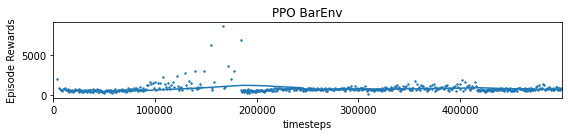

In [91]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "PPO BarEnv")